In [ ]:
!nvidia-smi

Mon May  9 20:00:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   39C    P0    47W / 160W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd

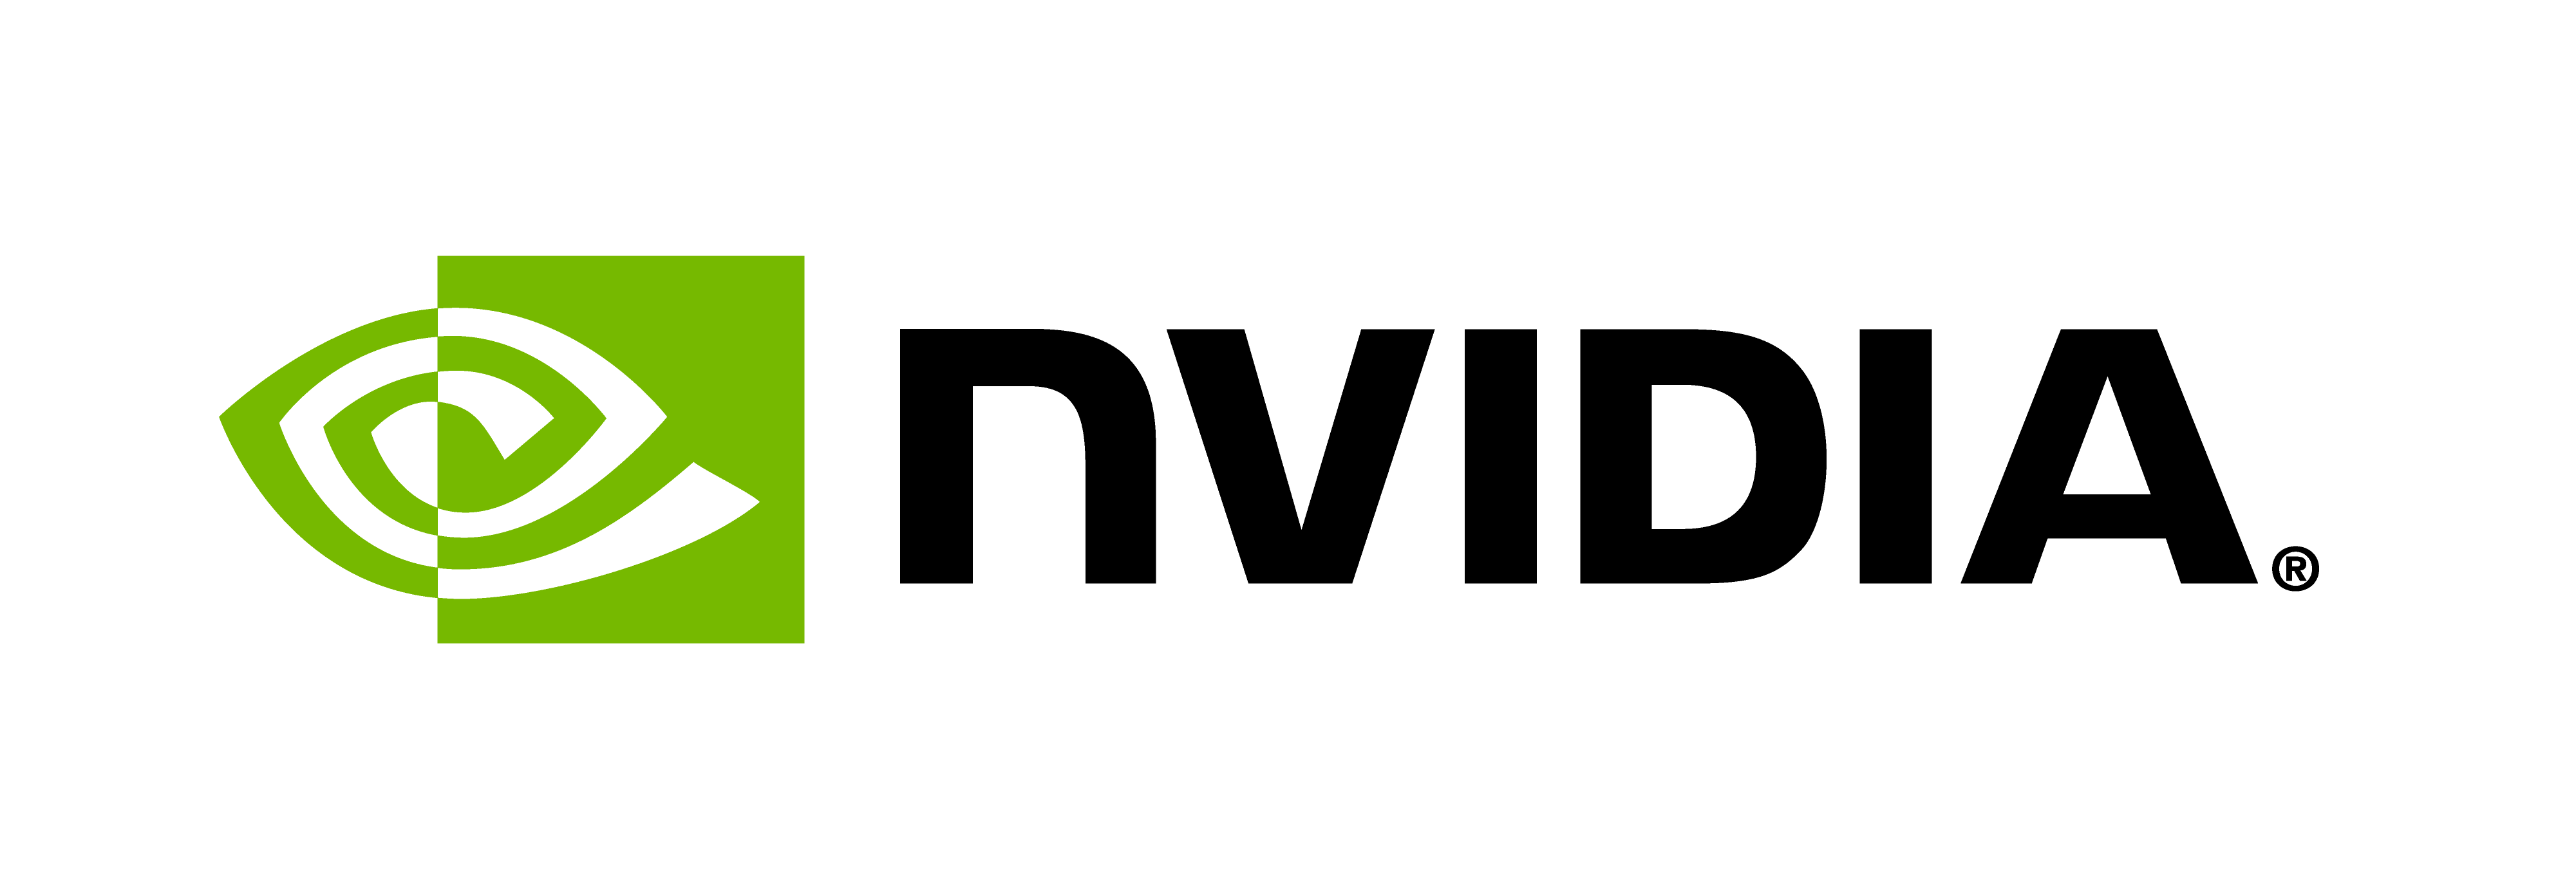

In [ ]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/JeapuI9ypk0" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/opt/conda/envs/rapids/lib/python3.8/site-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# Desafio 3 - Detecção de Fraude

Você precisa propor uma solução para detecção e análise de fraudes que possam reduzir os riscos da empresa e garantir margens saudáveis. Lembre-se, que o resultado do seu trabalho dará ainda mais visibilidade para você e sua área. Seja criterioso, utilize bons argumentos, fatos e justificativas para sua proposta, bem como, claro, faça uma boa execução do seu projeto.

# Programação em GPU

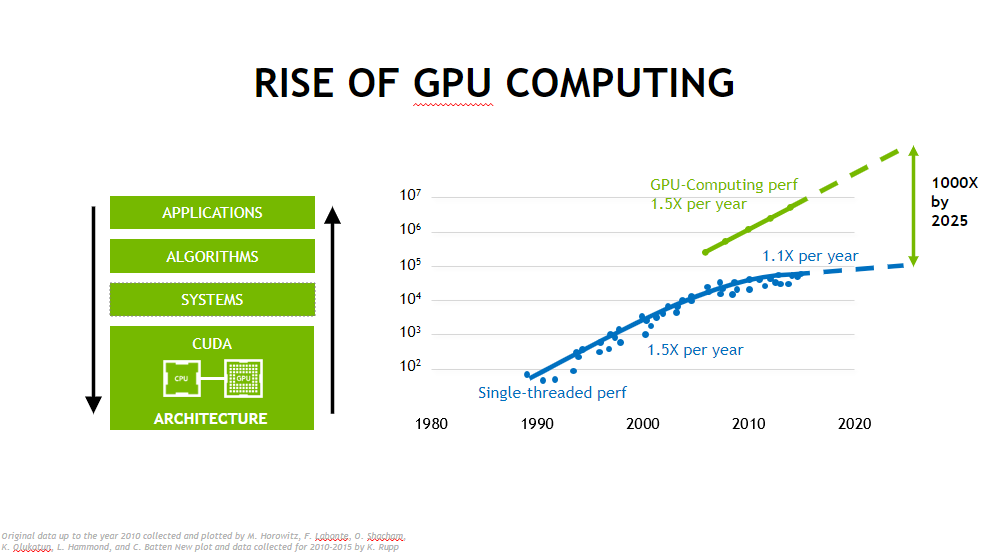

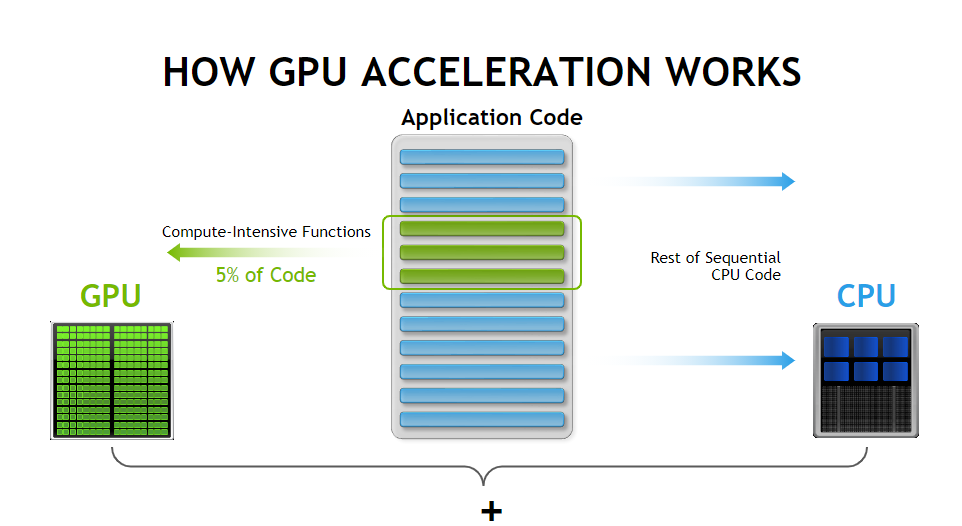

# Preparação do Ambiente

Nesta seção vamos importar os pacotes que são necessários para a execução deste notebook. Estamos importando tanto pacotes que irão realizar o treinamento do modelo de Machine Learning na CPU (Sklearn) quanto o pacote que irá treinar os modelos em GPU (Rapids).

**Importante**: Caso você esteja executando através do Colaboratory do Google utilize essa referência para a preparação do ambiente: https://colab.research.google.com/github/ritchieng/deep-learning-wizard/blob/master/docs/machine_learning/gpu/rapids_cudf.ipynb. Este é um notebook com o passo a passo para a instalação das bibliotecas necessárias instalação das bibliotecas do [Rapids](https://rapids.ai/).

## Importação dos pacotes em Python

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas para tratamento de dados em cpu
import pandas as pd
import numpy as np

# Bibliotecas para visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para treinamento e cálculo de métricas em CPU
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.model_selection import train_test_split as cpu_train_test_split
from sklearn.ensemble import RandomForestClassifier as cpu_RandomForestClassifier
from sklearn.metrics import accuracy_score as cpu_accuracy_score
from sklearn.metrics import confusion_matrix as cpu_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression as cpu_LogisticRegression

# Bibliotecas para treinamento e cálculo de métricas em GPU
from cuml.preprocessing import LabelEncoder as gpu_LabelEncoder
from cuml.preprocessing import Normalizer as gpu_Normalizer
from cuml import train_test_split as gpu_train_test_split
from cuml.ensemble import RandomForestClassifier as gpu_RandomForestClassifier
from cuml.metrics import accuracy_score as gpu_accuracy_score
from cuml.metrics import confusion_matrix as gpu_confusion_matrix
from cuml import LogisticRegression as gpu_LogisticRegression
import cupy
import cudf
import cuxfilter

# Algoritmo XGBoost
from xgboost import XGBClassifier

In [ ]:
# Evita que o pandas apresente valores em notação científica
pd.set_option('display.float_format', lambda x: '%.5f' % x)

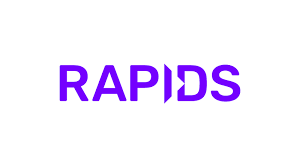

Instalação das bibliotecas do RAPIDS:
- [cuDF - GPU DataFrames](https://github.com/rapidsai/cudf)
- [cuML - GPU Machine Learning Algorithms](https://github.com/rapidsai/cuml)
- [cuGraph - GPU Graph Analytics](https://github.com/rapidsai/cugraph)
- [cuSpatial - GPU-Accelerated Spatial and Trajectory Data Management and Analytics Library](https://github.com/rapidsai/cuspatial)
- [cuSignal](https://github.com/rapidsai/cusignal)
- [XGBoost](https://rapids.ai/xgboost.html)
- [cuCIM](https://github.com/rapidsai/cucim)

### Medição de tempo de execução de uma célula

Utilizando o código no início da célula:
```python
%%time
```

Veja o exemplo abaixo:

In [ ]:
%%time
print("I am AI")

I am AI
CPU times: user 51 µs, sys: 7 µs, total: 58 µs
Wall time: 56 µs


### Environment Sanity Check

Nesta seção estamos verificando qual e se existe pelo menos uma GPU disponível onde este notebook está sendo executado. Caso você esteja executando no Colaboratory, o Google pode disponibilizar alguma das GPUs: K80s, T4s, P4s ou P100s.

In [2]:
!nvidia-smi

Mon May  9 22:59:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Carregamento do Dataset

Nesta seção estamos carregando o dataset de fraudes em transações bancárias tanto em CPU quanto em GPU. Para a leitura do dataset direto para a memória da GPU estamos utilizando a biblioteca **cuDF**, muito semelhante ao **Pandas**.

#### GPU

In [ ]:
%%time
# Leitura do Dataset utilizando cudf
gpu_data = cudf.read_csv('./PS_20174392719_1491204439457_log.csv')
gpu_data.head(2)

CPU times: user 2.54 s, sys: 1.01 s, total: 3.55 s
Wall time: 4.9 s


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64000,C1231006815,170136.00000,160296.36000,M1979787155,0.00000,0.00000,0,0
1,1,PAYMENT,1864.28000,C1666544295,21249.00000,19384.72000,M2044282225,0.00000,0.00000,0,0


In [ ]:
%%time
gpu_data.columns

CPU times: user 131 µs, sys: 25 µs, total: 156 µs
Wall time: 162 µs


Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

#### CPU

In [ ]:
%%time
# Leitura do Dataset utilizando cudf
data = pd.read_csv('./PS_20174392719_1491204439457_log.csv')
data.head(2)

CPU times: user 13 s, sys: 1.49 s, total: 14.5 s
Wall time: 14.4 s


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64000,C1231006815,170136.00000,160296.36000,M1979787155,0.00000,0.00000,0,0
1,1,PAYMENT,1864.28000,C1666544295,21249.00000,19384.72000,M2044282225,0.00000,0.00000,0,0


In [ ]:
%%time
data.columns

CPU times: user 9 µs, sys: 1 µs, total: 10 µs
Wall time: 13.6 µs


Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

## Avaliando o dataset

#### GPU

In [ ]:
%%time
gpu_data.type.unique()

CPU times: user 85.7 ms, sys: 11.6 ms, total: 97.3 ms
Wall time: 129 ms


0     CASH_IN
1    CASH_OUT
2       DEBIT
3     PAYMENT
4    TRANSFER
Name: type, dtype: object

In [ ]:
%%time
gpu_data.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype
---  ------          -----
 0   step            int64
 1   type            object
 2   amount          float64
 3   nameOrig        object
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64
 10  isFlaggedFraud  int64
dtypes: float64(5), int64(3), object(3)
memory usage: 633.4+ MB
CPU times: user 10.2 ms, sys: 310 µs, total: 10.5 ms
Wall time: 9.48 ms


In [ ]:
%%time
# Verifica valores faltantes
gpu_data.isnull().sum()

CPU times: user 2.89 ms, sys: 23.3 ms, total: 26.1 ms
Wall time: 167 ms


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

#### CPU

In [ ]:
%%time
data.type.unique()

CPU times: user 581 ms, sys: 22.8 ms, total: 604 ms
Wall time: 599 ms


array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [ ]:
%%time
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
CPU times: user 5.86 ms, sys: 4.29 ms, total: 10.1 ms
Wall time: 9.6 ms


In [ ]:
%%time
# Verifica valores faltantes
data.isnull().sum()

CPU times: user 1.53 s, sys: 16.2 ms, total: 1.54 s
Wall time: 1.54 s


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## Análise Exploratória

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int32
CPU times: user 11 s, sys: 1.49 s, total: 12.5 s
Wall time: 12.5 s


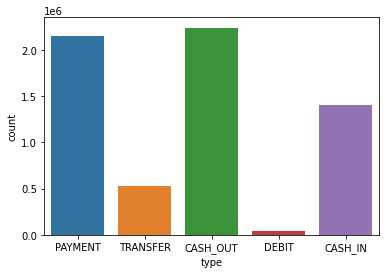

In [ ]:
%%time
print(gpu_data.type.value_counts())
_ = sns.countplot(x="type", data=gpu_data.to_pandas())

Variável resposta

0    6354407
1       8213
Name: isFraud, dtype: int32
CPU times: user 5.1 s, sys: 1.73 s, total: 6.83 s
Wall time: 6.82 s


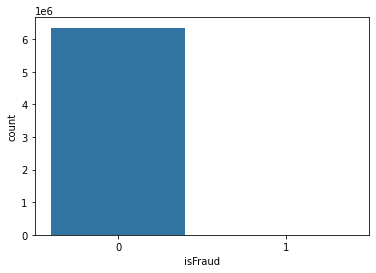

In [ ]:
%%time
print(gpu_data.isFraud.value_counts())
_ = sns.countplot(x="isFraud", data=gpu_data.to_pandas())

In [ ]:
8213/(6354407+8213)*100

0.12908204481801522

0    6362604
1         16
Name: isFlaggedFraud, dtype: int32
CPU times: user 5.19 s, sys: 1.57 s, total: 6.76 s
Wall time: 6.75 s


<AxesSubplot:xlabel='isFlaggedFraud', ylabel='count'>

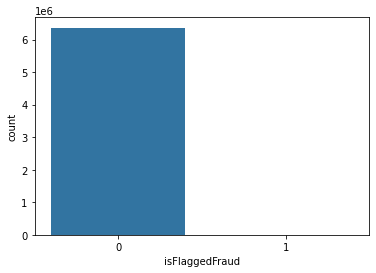

In [ ]:
%%time
print(gpu_data.isFlaggedFraud.value_counts())
sns.countplot("isFlaggedFraud", data=gpu_data.to_pandas())

## Engenharia de Features

### Remoção de Amostras Duplicadas

#### GPU

In [ ]:
%%time
gpu_data.describe()

CPU times: user 484 ms, sys: 25.4 ms, total: 509 ms
Wall time: 779 ms


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00000,6362620.00000,6362620.00000,6362620.00000,6362620.00000,6362620.00000,6362620.00000,6362620.00000
mean,243.39725,179861.90355,833883.10407,855113.66858,1100701.66652,1224996.39820,0.00129,0.00000
std,142.33197,603858.23146,2888242.67304,2924048.50295,3399180.11299,3674128.94212,0.03590,0.00159
min,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,156.00000,13389.57000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,239.00000,74871.94000,14208.00000,0.00000,132705.66500,214661.44000,0.00000,0.00000
75%,335.00000,208721.47750,107315.17500,144258.41000,943036.70750,1111909.25000,0.00000,0.00000
max,743.00000,92445516.64000,59585040.37000,49585040.37000,356015889.35000,356179278.92000,1.00000,1.00000


In [ ]:
%%time
gpu_data.shape

CPU times: user 54 µs, sys: 0 ns, total: 54 µs
Wall time: 59.4 µs


(6362620, 11)

In [ ]:
%%time
gpu_data.drop_duplicates(keep=False, inplace=True)

CPU times: user 145 ms, sys: 16.9 ms, total: 161 ms
Wall time: 319 ms


In [ ]:
%%time
gpu_data.shape

CPU times: user 39 µs, sys: 0 ns, total: 39 µs
Wall time: 42.7 µs


(6362620, 11)

#### CPU

In [ ]:
%%time
data.describe()

CPU times: user 1.92 s, sys: 565 ms, total: 2.49 s
Wall time: 2.49 s


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00000,6362620.00000,6362620.00000,6362620.00000,6362620.00000,6362620.00000,6362620.00000,6362620.00000
mean,243.39725,179861.90355,833883.10407,855113.66858,1100701.66652,1224996.39820,0.00129,0.00000
std,142.33197,603858.23146,2888242.67304,2924048.50295,3399180.11299,3674128.94212,0.03590,0.00159
min,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,156.00000,13389.57000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,239.00000,74871.94000,14208.00000,0.00000,132705.66500,214661.44000,0.00000,0.00000
75%,335.00000,208721.47750,107315.17500,144258.41000,943036.70750,1111909.25000,0.00000,0.00000
max,743.00000,92445516.64000,59585040.37000,49585040.37000,356015889.35000,356179278.92000,1.00000,1.00000


In [ ]:
%%time
data.shape

CPU times: user 23 µs, sys: 0 ns, total: 23 µs
Wall time: 27.2 µs


(6362620, 11)

In [ ]:
%%time
# Drop Duplicates
data.drop_duplicates(keep=False, inplace=True)

CPU times: user 19.2 s, sys: 1.92 s, total: 21.1 s
Wall time: 21.1 s


In [ ]:
%%time
data.shape

CPU times: user 21 µs, sys: 4 µs, total: 25 µs
Wall time: 27.9 µs


(6362620, 11)

### Categorização das Transferências

#### GPU

In [ ]:
%%time
def transfer_category(x):
    if x >= 75000:
        return('HIGH')
    elif x < 75000 and x >= 14000:
        return('MODERATE')
    elif x < 14000:
        return('LOW')
    else:
        return("EXTREMLY LOW")
gpu_data['transfer_amount_category'] = gpu_data.to_pandas().amount.apply(transfer_category)    
gpu_data.head(2)

CPU times: user 7.78 s, sys: 1.58 s, total: 9.36 s
Wall time: 9.36 s


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,transfer_amount_category
1286,1,CASH_IN,270.78000,C619985571,4184966.65000,4185237.43000,C875917495,3019.00000,0.00000,0,0,LOW
2682,1,CASH_IN,484.57000,C1859216983,5422437.76000,5422922.33000,C657736958,5638778.53000,5579568.65000,0,0,LOW


#### CPU

In [ ]:
%%time
def transfer_category(x):
    if x >= 75000:
        return('HIGH')
    elif x < 75000 and x >= 14000:
        return('MODERATE')
    elif x < 14000:
        return('LOW')
    else:
        return("EXTREMLY LOW")
data['transfer_amount_category'] = data.amount.apply(transfer_category)    
data.head(2)

CPU times: user 3.07 s, sys: 224 ms, total: 3.29 s
Wall time: 3.29 s


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,transfer_amount_category
0,1,PAYMENT,9839.64000,C1231006815,170136.00000,160296.36000,M1979787155,0.00000,0.00000,0,0,LOW
1,1,PAYMENT,1864.28000,C1666544295,21249.00000,19384.72000,M2044282225,0.00000,0.00000,0,0,LOW


### Features Textuais

#### GPU

In [ ]:
%%time
gpu_label_encoder = gpu_LabelEncoder()
gpu_data['type_encode'] = gpu_label_encoder.fit_transform(gpu_data['type']) 
gpu_data['nameOrig_encode'] = gpu_label_encoder.fit_transform(gpu_data['nameOrig']) 
gpu_data['nameDest_encode'] = gpu_label_encoder.fit_transform(gpu_data['nameDest']) 
gpu_data['transfer_amount_category_encode'] = gpu_label_encoder.fit_transform(gpu_data['transfer_amount_category'])

CPU times: user 702 ms, sys: 96.4 ms, total: 799 ms
Wall time: 1.35 s


In [ ]:
%%time
gpu_data.head(2)

CPU times: user 1.99 ms, sys: 0 ns, total: 1.99 ms
Wall time: 1.87 ms


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,transfer_amount_category,type_encode,nameOrig_encode,nameDest_encode,transfer_amount_category_encode
1286,1,CASH_IN,270.78000,C619985571,4184966.65000,4185237.43000,C875917495,3019.00000,0.00000,0,0,LOW,0,5103582,535429,1
2682,1,CASH_IN,484.57000,C1859216983,5422437.76000,5422922.33000,C657736958,5638778.53000,5579568.65000,0,0,LOW,0,2822763,470457,1


In [ ]:
%%time
gpu_normalizer = gpu_Normalizer()
amount_scale = gpu_normalizer.fit_transform(gpu_data.amount.values.reshape(1,-1))
gpu_data['amount_norm'] = amount_scale.reshape(-1,1)
amount_oldbalanceOrg = gpu_normalizer.fit_transform(gpu_data.oldbalanceOrg.values.reshape(1,-1))
gpu_data['oldbalanceOrg_norm'] = amount_oldbalanceOrg.reshape(-1,1)
amount_newbalanceOrig = gpu_normalizer.fit_transform(gpu_data.newbalanceOrig.values.reshape(1,-1))
gpu_data['newbalanceOrig_norm'] = amount_newbalanceOrig.reshape(-1,1)
amount_oldbalanceDest= gpu_normalizer.fit_transform(gpu_data.oldbalanceDest.values.reshape(1,-1))
gpu_data['oldbalanceDest_norm'] = amount_oldbalanceDest.reshape(-1,1)
amount_newbalanceDest = gpu_normalizer.fit_transform(gpu_data.newbalanceDest.values.reshape(1,-1))
gpu_data['newbalanceDest_norm'] = amount_newbalanceDest.reshape(-1,1)

CPU times: user 710 ms, sys: 369 ms, total: 1.08 s
Wall time: 1.48 s


In [ ]:
%%time
gpu_data.head(2)

CPU times: user 2.73 ms, sys: 0 ns, total: 2.73 ms
Wall time: 2.64 ms


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,transfer_amount_category,type_encode,nameOrig_encode,nameDest_encode,transfer_amount_category_encode,amount_norm,oldbalanceOrg_norm,newbalanceOrig_norm,oldbalanceDest_norm,newbalanceDest_norm
1286,1,CASH_IN,270.78000,C619985571,4184966.65000,4185237.43000,C875917495,3019.00000,0.00000,0,...,LOW,0,5103582,535429,1,0.00000,0.00055,0.00054,0.00000,0.00000
2682,1,CASH_IN,484.57000,C1859216983,5422437.76000,5422922.33000,C657736958,5638778.53000,5579568.65000,0,...,LOW,0,2822763,470457,1,0.00000,0.00072,0.00071,0.00063,0.00057


#### CPU

In [ ]:
%%time
label_encoder = LabelEncoder() 
data['type_encode'] = label_encoder.fit_transform(data['type']) 
data['nameOrig_encode'] = label_encoder.fit_transform(data['nameOrig']) 
data['nameDest_encode'] = label_encoder.fit_transform(data['nameDest']) 
data['transfer_amount_category_encode'] = label_encoder.fit_transform(data['transfer_amount_category']) 

CPU times: user 1min 4s, sys: 1.77 s, total: 1min 6s
Wall time: 1min 6s


In [ ]:
%%time
data.head(2)

CPU times: user 279 µs, sys: 0 ns, total: 279 µs
Wall time: 284 µs


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,transfer_amount_category,type_encode,nameOrig_encode,nameDest_encode,transfer_amount_category_encode
0,1,PAYMENT,9839.64000,C1231006815,170136.00000,160296.36000,M1979787155,0.00000,0.00000,0,0,LOW,3,757869,1662094,1
1,1,PAYMENT,1864.28000,C1666544295,21249.00000,19384.72000,M2044282225,0.00000,0.00000,0,0,LOW,3,2188998,1733924,1


In [ ]:
%%time
normalizer = Normalizer()
amount_scale = normalizer.fit_transform(data.amount.values.reshape(1,-1))
data['amount_norm'] = amount_scale.reshape(-1,1)
amount_oldbalanceOrg = normalizer.fit_transform(data.oldbalanceOrg.values.reshape(1,-1))
data['oldbalanceOrg_norm'] = amount_oldbalanceOrg.reshape(-1,1)
amount_newbalanceOrig = normalizer.fit_transform(data.newbalanceOrig.values.reshape(1,-1))
data['newbalanceOrig_norm'] = amount_newbalanceOrig.reshape(-1,1)
amount_oldbalanceDest= normalizer.fit_transform(data.oldbalanceDest.values.reshape(1,-1))
data['oldbalanceDest_norm'] = amount_oldbalanceDest.reshape(-1,1)
amount_newbalanceDest = normalizer.fit_transform(data.newbalanceDest.values.reshape(1,-1))
data['newbalanceDest_norm'] = amount_newbalanceDest.reshape(-1,1)

CPU times: user 254 ms, sys: 136 ms, total: 390 ms
Wall time: 389 ms


In [ ]:
%%time
data.head(2)

CPU times: user 131 µs, sys: 0 ns, total: 131 µs
Wall time: 135 µs


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,transfer_amount_category,type_encode,nameOrig_encode,nameDest_encode,transfer_amount_category_encode,amount_norm,oldbalanceOrg_norm,newbalanceOrig_norm,oldbalanceDest_norm,newbalanceDest_norm
0,1,PAYMENT,9839.64000,C1231006815,170136.00000,160296.36000,M1979787155,0.00000,0.00000,0,...,LOW,3,757869,1662094,1,0.00001,0.00002,0.00002,0.00000,0.00000
1,1,PAYMENT,1864.28000,C1666544295,21249.00000,19384.72000,M2044282225,0.00000,0.00000,0,...,LOW,3,2188998,1733924,1,0.00000,0.00000,0.00000,0.00000,0.00000


## Modelagem

Na etapa de modelagem vamos construir alguns modelos para executar a tarefa de classificação das transações que são fraude e transações que não são fraude.

### Split - Treino/Teste

#### GPU

In [ ]:
%%time
X = gpu_data[['type_encode','nameOrig_encode','nameDest_encode',
          'transfer_amount_category_encode','amount_norm',
          'oldbalanceOrg_norm','newbalanceOrig_norm',
          'oldbalanceDest_norm','newbalanceDest_norm']]
y = gpu_data["isFraud"]
X_cudf_train, X_cudf_test, y_train, y_test = gpu_train_test_split(X, y,
                                                    test_size = 0.33, 
                                                    stratify=y,
                                                    random_state = 42)

X_cudf_train = X_cudf_train.astype(np.float32)
X_cudf_test = X_cudf_test.astype(np.float32)

y_cudf_train = cudf.Series(y_train.values)
y_cudf_test = cudf.Series(y_test.values)

CPU times: user 183 ms, sys: 86 ms, total: 269 ms
Wall time: 722 ms


#### CPU

In [ ]:
%%time
X = data[['type_encode','nameOrig_encode','nameDest_encode',
          'transfer_amount_category_encode','amount_norm',
          'oldbalanceOrg_norm','newbalanceOrig_norm',
          'oldbalanceDest_norm','newbalanceDest_norm']]
y = data["isFraud"]
X_train, X_test, y_train, y_test = cpu_train_test_split(X, y,
                                                    test_size = 0.33, 
                                                    stratify=y,
                                                    random_state = 42)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

CPU times: user 4.77 s, sys: 1.4 s, total: 6.16 s
Wall time: 6.16 s


### Treinamento do modelo - Logistic Regression

#### GPU

In [ ]:
%%time
# Criando o modelo Regressão Logistica em GPU
gpu_clf = gpu_LogisticRegression()   
  
# Treinamento do modelo Regressão Logistica em GPU
gpu_clf.fit(X_cudf_train, y_cudf_train) 

[W] [20:03:14.086574] L-BFGS line search failed (code 4); stopping at the last valid step
CPU times: user 94.9 ms, sys: 3.87 ms, total: 98.8 ms
Wall time: 158 ms


LogisticRegression()

In [ ]:
%%time
# Predições
y_pred_gpu = gpu_clf.predict(X_cudf_test) 

CPU times: user 6.08 ms, sys: 7.79 ms, total: 13.9 ms
Wall time: 43.4 ms


In [ ]:
%%time
# Calculando as métricas do modelo (Acurácia, Matriz de confusão)
print("Acurácia: ", gpu_accuracy_score(y_cudf_test, y_pred_gpu)) 
print("Matriz de confusão: ", gpu_confusion_matrix(y_cudf_test, y_pred_gpu.astype(np.int64)))

Acurácia:  0.9987093210220337
Matriz de confusão:  [[2096954       0]
 [   2710       0]]
CPU times: user 325 ms, sys: 180 ms, total: 505 ms
Wall time: 744 ms


#### CPU

In [ ]:
%%time
# Criando o modelo Regressão Logistica em CPU
cpu_clf = cpu_LogisticRegression()   
  
# Treinamento do modelo Regressão Logistica em CPU
cpu_clf.fit(X_train, y_train) 

CPU times: user 12.2 s, sys: 2.17 s, total: 14.4 s
Wall time: 14.4 s


LogisticRegression()

In [ ]:
%%time
# Predições
y_pred_cpu = cpu_clf.predict(X_test) 

CPU times: user 149 ms, sys: 84.2 ms, total: 233 ms
Wall time: 232 ms


In [ ]:
%%time
# Calculando as métricas do modelo (Acurácia, Matriz de confusão)
print("Acurácia: ", cpu_accuracy_score(y_test, y_pred_cpu))
print("Matriz de confusão: ", cpu_confusion_matrix(y_test, y_pred_cpu))

Acurácia:  0.9987093179150007
Matriz de confusão:  [[2096955       0]
 [   2710       0]]
CPU times: user 2.96 s, sys: 31.4 ms, total: 2.99 s
Wall time: 2.99 s


### Treinamento do modelo - RandomForest

#### GPU

In [ ]:
%%time
# Criando o modelo Random Forest em GPU
gpu_clf = gpu_RandomForestClassifier(n_estimators = 5, random_state = 42)   
  
# Treinamento do modelo Random Forest em GPU
gpu_clf.fit(X_cudf_train, y_cudf_train) 

CPU times: user 1.33 s, sys: 641 ms, total: 1.97 s
Wall time: 1.11 s


RandomForestClassifier()

In [ ]:
%%time
# Predições
y_pred_gpu = gpu_clf.predict(X_cudf_test) 

CPU times: user 2.31 s, sys: 47.6 ms, total: 2.36 s
Wall time: 324 ms


#### CPU

In [ ]:
%%time
# Criando o modelo Random Forest em CPU
cpu_clf = cpu_RandomForestClassifier(n_estimators = 5, random_state = 42)   
  
# Treinamento do modelo Random Forest em CPU
cpu_clf.fit(X_train, y_train) 

CPU times: user 1min 30s, sys: 1.09 s, total: 1min 32s
Wall time: 1min 32s


RandomForestClassifier(n_estimators=5, random_state=42)

In [ ]:
%%time
# Predições
y_pred_cpu = cpu_clf.predict(X_test) 

CPU times: user 1.44 s, sys: 48.2 ms, total: 1.49 s
Wall time: 1.49 s


### Metrificação do Modelo - Random Forest

#### GPU

In [ ]:
%%time
# Calculando as métricas do modelo (Acurácia, Matriz de confusão)
print("Acurácia: ", gpu_accuracy_score(y_cudf_test, y_pred_gpu)) 
print("Matriz de confusão: ", gpu_confusion_matrix(y_cudf_test, y_pred_gpu.astype(np.int64)))

Acurácia:  0.999626636505127
Matriz de confusão:  [[2096907      47]
 [    737    1973]]
CPU times: user 76 ms, sys: 32.3 ms, total: 108 ms
Wall time: 341 ms


CPU times: user 2.84 s, sys: 40 ms, total: 2.88 s
Wall time: 2.87 s


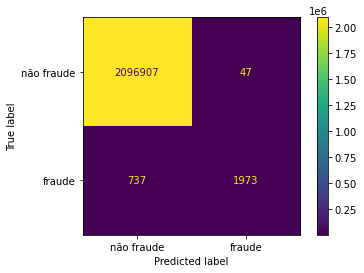

In [ ]:
%%time
cm = cpu_confusion_matrix(y_cudf_test.to_pandas(), y_pred_gpu.to_pandas().astype(np.int64))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['não fraude', 'fraude'])
ax = disp.plot(values_format='d') 

In [ ]:
%%time
# Função que comentamos em sala sobre as propabilidades da classificação
y_pred_proba_gpu = gpu_clf.predict_proba(X_cudf_test)

CPU times: user 1.79 s, sys: 46.7 ms, total: 1.84 s
Wall time: 231 ms


In [ ]:
%%time
print(y_pred_proba_gpu[:5])

              0       1
94707   1.00000 0.00000
3775739 1.00000 0.00000
1265712 0.99999 0.00001
5700584 1.00000 0.00000
499673  1.00000 0.00000
CPU times: user 7.51 ms, sys: 279 µs, total: 7.78 ms
Wall time: 7.14 ms


#### CPU

In [ ]:
%%time
# Calculando as métricas do modelo (Acurácia, Matriz de confusão)
print("Acurácia: ", cpu_accuracy_score(y_test, y_pred_cpu))
print("Matriz de confusão: ", cpu_confusion_matrix(y_test, y_pred_cpu))

Acurácia:  0.9994980151595612
Matriz de confusão:  [[2096934      21]
 [   1033    1677]]
CPU times: user 2.93 s, sys: 19.1 ms, total: 2.94 s
Wall time: 2.94 s


CPU times: user 2.83 s, sys: 15.2 ms, total: 2.84 s
Wall time: 2.84 s


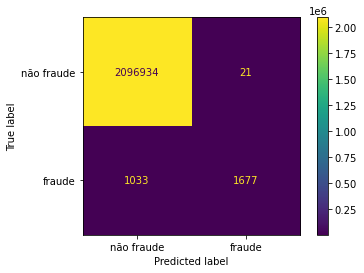

In [ ]:
%%time
cm = cpu_confusion_matrix(y_test, y_pred_cpu)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['não fraude', 'fraude'])
_ = disp.plot(values_format='d') 

In [ ]:
%%time
# Função que comentamos em sala sobre as propabilidades da classificação
y_pred_proba = cpu_clf.predict_proba(X_test)

CPU times: user 1.44 s, sys: 44 ms, total: 1.48 s
Wall time: 1.48 s


In [ ]:
%%time
print(y_pred_proba[:5])

[[1.00000000e+00 0.00000000e+00]
 [9.99471341e-01 5.28658623e-04]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]]
CPU times: user 851 µs, sys: 67 µs, total: 918 µs
Wall time: 957 µs


### Treinamento do modelo - XGBoost

#### GPU

In [ ]:
%%time

# Parametrização do XGBoost
params = {'learning_rate': 0.1,
          'colsample_bytree' : 0.3,
          'max_depth': 5,
          'objective': 'binary:logistic',
          'alpha' : 10,          
          'tree_method':'gpu_hist',
          'predictor': 'gpu_predictor',
          'n_estimators': 100}

# Treinamento do modelo XGBoost
gpu_trained_model = XGBClassifier(**params)
gpu_trained_model.fit(X_train, y_train, eval_set=[(X_cudf_train, y_cudf_train.to_cupy().get()), 
                                                  (X_cudf_test, y_cudf_test.to_cupy().get())],
                      eval_metric='auc', verbose=False)

CPU times: user 4.39 s, sys: 352 ms, total: 4.75 s
Wall time: 3.09 s


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3,
              enable_categorical=False, gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=80,
              num_parallel_tree=1, predictor='gpu_predictor', random_state=0,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [ ]:
%%time
# Predições
y_pred_gpu = gpu_trained_model.predict(X_cudf_test) 

CPU times: user 100 ms, sys: 4.32 ms, total: 105 ms
Wall time: 127 ms


#### CPU

In [ ]:
%%time

# Parametrização do XGBoost
params = {'learning_rate': 0.1,
          'colsample_bytree' : 0.3,
          'max_depth': 5,
          'objective': 'binary:logistic',
          'alpha' : 10,
          'n_estimators': 100}

# Treinamento do modelo XGBoost
cpu_trained_model = XGBClassifier(**params)
cpu_trained_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
                      eval_metric='auc', verbose=False)

CPU times: user 27min 56s, sys: 13.8 s, total: 28min 10s
Wall time: 3min 54s


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=80, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=10, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='approx',
              validate_parameters=1, verbosity=None)

In [ ]:
%%time
# Predições
y_pred_cpu = cpu_trained_model.predict(X_test) 

CPU times: user 5.46 s, sys: 4.76 ms, total: 5.46 s
Wall time: 684 ms


### Metrificação do Modelo - XGBoost

#### GPU

In [ ]:
%%time
# Calculando as métricas do modelo (Acurácia, Matriz de confusão)
print("Acurácia: ", gpu_accuracy_score(y_cudf_test, y_pred_gpu)) 
print("Matriz de confusão: ", gpu_confusion_matrix(y_cudf_test, y_pred_gpu))

Acurácia:  0.9992151260375977
Matriz de confusão:  [[2096951       3]
 [   1645    1065]]
CPU times: user 82.7 ms, sys: 66.4 ms, total: 149 ms
Wall time: 258 ms


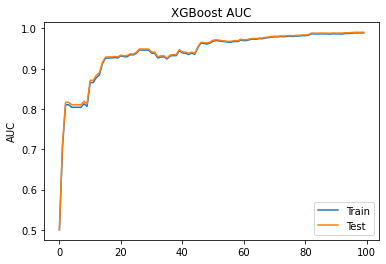

CPU times: user 197 ms, sys: 104 µs, total: 197 ms
Wall time: 199 ms


In [ ]:
%%time
fig, ax = plt.subplots()

evals_result = gpu_trained_model.evals_result()
x_axis = range(0, len(evals_result['validation_0']['auc']))

ax.plot(x_axis, evals_result['validation_0']['auc'], label='Train')
ax.plot(x_axis, evals_result['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

CPU times: user 2.82 s, sys: 40.3 ms, total: 2.86 s
Wall time: 2.87 s


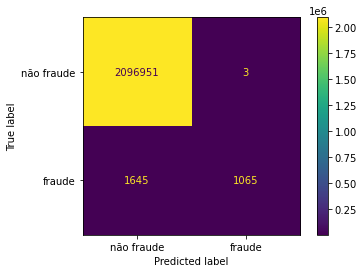

In [ ]:
%%time
cm = cpu_confusion_matrix(y_cudf_test.to_cupy().get(), y_pred_gpu.astype(np.int64))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['não fraude', 'fraude'])
ax = disp.plot(values_format='d') 

#### CPU

In [ ]:
%%time
# Calculando as métricas do modelo (Acurácia, Matriz de confusão)
print("Acurácia: ", cpu_accuracy_score(y_test, y_pred_cpu))
print("Matriz de confusão: ", cpu_confusion_matrix(y_test, y_pred_cpu))

Acurácia:  0.9992327347457809
Matriz de confusão:  [[2096949       6]
 [   1605    1105]]
CPU times: user 2.97 s, sys: 1.4 ms, total: 2.97 s
Wall time: 2.97 s


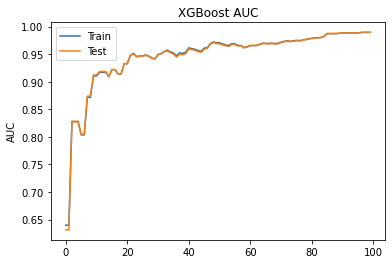

CPU times: user 195 ms, sys: 11.8 ms, total: 207 ms
Wall time: 202 ms


In [ ]:
%%time
fig, ax = plt.subplots()

evals_result = cpu_trained_model.evals_result()
x_axis = range(0, len(evals_result['validation_0']['auc']))

ax.plot(x_axis, evals_result['validation_0']['auc'], label='Train')
ax.plot(x_axis, evals_result['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

CPU times: user 2.84 s, sys: 5.14 ms, total: 2.85 s
Wall time: 2.84 s


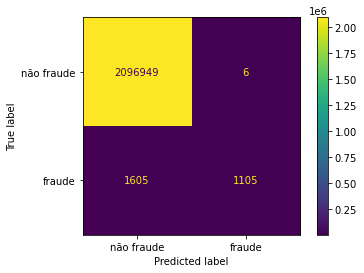

In [ ]:
%%time
cm = cpu_confusion_matrix(y_test, y_pred_cpu.astype(np.int64))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['não fraude', 'fraude'])
_ = disp.plot(values_format='d') 

## Conclusões

##### Como está a nossa detecção de fraudes nesta solução proposta?

Vamos recapitular as métricas que foram obtidas para o XGBoost que foi treinado para este desafio. Lembrando que estas métricas foram obtidas para os dados de teste:

**Modelo XGBoost**

Matriz de confusão

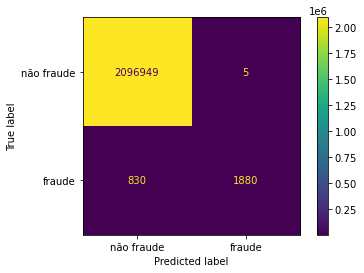

Neste cenário, 69% das fraudes foram detectadas corretamente com uma taxa verdadeiros negativos bem pequena (5 transações).

### Inferência

##### Por que o tempo de inferência é importante?

O tempo de inferência está diretamente ligado aos requisitos para colocar um modelo de Machine Learning em produção. Portanto, analisar as métricas de desempenho do modelo é fundamental, mas não é o único aspecto a ser levado em consideração ao definir que o modelo obtido atende todos os requisitos. Um dos requisitos do modelo pode ser o tempo de inferência. 

Vamos exemplificar um cenário onde o modelo que foi desenvolvido neste desafio seria colocado em produção.

## Referências

[Documentação - cuML](https://docs.rapids.ai/api/cuml/stable/api.html)

[RAPIDS Open GPU Data Science](https://rapids.ai/)

[NVIDIA Developer Blog](https://developer.nvidia.com/blog/)

[XGBoost - GPU Support](https://xgboost.readthedocs.io/en/latest/gpu/index.html)